# Custom Model: Resnet18 and DistilBert

##Data

###Download COCO Dataset

In [ ]:
# https://cocodataset.org/#download

# Images
!wget -c http://images.cocodataset.org/zips/train2014.zip
!unzip train2014.zip
!rm train2014.zip

!wget -c http://images.cocodataset.org/zips/val2014.zip
!unzip val2014.zip
!rm val2014.zip

# Captions
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip annotations_trainval2014.zip
!rm annotations_trainval2014.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000323327.jpg  
 extracting: val2014/COCO_val2014_000000338581.jpg  
 extracting: val2014/COCO_val2014_000000039656.jpg  
 extracting: val2014/COCO_val2014_000000071667.jpg  
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.j

###Karpathy Split

In [ ]:
import torch
from torchvision.datasets import CocoCaptions
from torchvision.transforms import PILToTensor
from torch.utils.data import ConcatDataset, random_split
from torchvision.models import ResNet18_Weights

# Karpathy split (https://arxiv.org/pdf/1412.2306.pdf)

# for reproducibility
torch.manual_seed(42)

train_2014_ds = CocoCaptions(
    root = 'train2014/',
    annFile = 'annotations/captions_train2014.json',
    transform = ResNet18_Weights.IMAGENET1K_V1.transforms(),
    target_transform = lambda x: x[:5]
)
val_2014_ds = CocoCaptions(
    root = 'val2014/',
    annFile = 'annotations/captions_val2014.json',
    transform=ResNet18_Weights.IMAGENET1K_V1.transforms(),
    target_transform = lambda x: x[:5]
)

train_ds, val_ds, test_ds = random_split(val_2014_ds, [len(val_2014_ds) - 10000, 5000, 5000])
train_ds = ConcatDataset([train_2014_ds, train_ds])


loading annotations into memory...
Done (t=1.14s)
creating index...
index created!
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


In [ ]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [ ]:
print(f'Training set size: {len(train_ds)}')
print(f'Validation set size: {len(val_ds)}')
print(f'Test set size: {len(test_ds)}')

Training set size: 113287
Validation set size: 5000
Test set size: 5000


## Custom Model

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [4]:
from timm import create_model

vit_model = create_model('vit_base_patch16_224', pretrained=True)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [5]:
from transformers import DistilBertTokenizerFast, DistilBertModel

text_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [6]:
# https://arxiv.org/pdf/2103.00020.pdf
import os
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights
from transformers import DistilBertTokenizerFast, DistilBertModel
from tqdm.auto import tqdm

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # image encoder
        # https://pytorch.org/vision/stable/models.html
        self.image_encoder = vit_model.to(device)
        self.image_encoder.head = nn.Identity()  # Replace the classifier head with an identity function
        # freeze encoder parameters
        for param in self.image_encoder.parameters():
            param.requires_grad = False

        self.ie_linear_1 = nn.Linear(768,256)
        self.ie_linear_2 = nn.Linear(256,128)

        # text encoder
        # https://huggingface.co/distilbert/distilbert-base-uncased
        self.text_encoder = text_model.to(device)
        # freeze encoder parameters
        for param in self.text_encoder.parameters():
            param.requires_grad = False
        self.te_linear_1 = nn.Linear(768,256)
        self.te_linear_2 = nn.Linear(256,128)


    def forward(self, images, texts):

        images = self.image_encoder(images)
        images = F.relu(self.ie_linear_1(images))
        images = F.normalize(self.ie_linear_2(images))

        texts = self.text_encoder(**texts)
        texts = texts.last_hidden_state[:,0,:] # cls token
        texts = F.relu(self.te_linear_1(texts))
        texts = F.normalize(self.te_linear_2(texts))

        cosine_similartiy = images @ texts.T


        return cosine_similartiy


In [7]:
import gdown

load_checkpoint = True
# ckpt_url = 'https://drive.google.com/file/d/1YVByA2v4AnnZ67vrdY13X5tLl-0w-OCy/view?usp=sharing'
ckpt_path = '/content/drive/MyDrive/cs 445/project/ckpt/10_16.524.pt'
# ckpt_path = './ckpt.pt'

# gdown.download(ckpt_url, ckpt_path, fuzzy=True)

# model
model = Model().to(device)
if load_checkpoint and os.path.exists(ckpt_path):
    model.load_state_dict(torch.load(ckpt_path, map_location=torch.device(device)))
    print("Loaded checkpoint")
print(model)

Loaded checkpoint
Model(
  (image_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(

In [8]:
model = Model().to(device)


##Loss Function

In [9]:
# https://towardsdatascience.com/clip-model-and-the-importance-of-multimodal-embeddings-1c8f6b13bf72

def Loss(cosine_similartiy):

    num_captions_per_image = 5
    batch_size = cosine_similartiy.size(0)

    loss_images, loss_texts = 0, 0
    labels = torch.arange(batch_size).to(device)

    for i in range(num_captions_per_image):
        loss_images += F.cross_entropy(cosine_similartiy[:,i*batch_size:(i+1)*batch_size], labels)
        loss_texts += F.cross_entropy(cosine_similartiy[:,i*batch_size:(i+1)*batch_size].T, labels)

    loss = (loss_images + loss_texts) / 2

    return loss


##Evaluate

In [10]:
def evaluate(model, data_loader):

    loss = 0
    correct_matches = 0
    total_samples = 0

    model.eval()
    for images, captions in tqdm(data_loader):

        images = images.to(device)
        captions = [c for captions_tuple in captions for c in captions_tuple]
        captions = tokenizer(captions, return_tensors='pt', padding=True, truncation=True).to(device)
        cosine_similartiy = model(images, captions)

        loss += Loss(cosine_similartiy).detach().to('cpu')

        # accuracy
        predictions = cosine_similartiy.argmax(dim=1)
        predictions = predictions % len(images)
        correct_matches += (predictions == torch.arange(len(images)).to(device)).sum().item()
        total_samples += len(images)

    loss /= len(data_loader)
    accuracy = correct_matches / total_samples

    return loss, accuracy


##Train

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# settings
epochs = 10
learning_rate = 0.001

# save checkpoint
ckpt_folder = '/content/drive/MyDrive/cs 445/project/ckpt'

# tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

# keep min validation loss
min_loss = 23.572

# train
train = True
if train:
    for epoch in range(epochs):

        train_loss = 0

        model.train()
        for images, captions in tqdm(train_dataloader):

            images = images.to(device)
            captions = [c for captions_tuple in captions for c in captions_tuple]
            captions = tokenizer(captions, return_tensors='pt', padding=True, truncation=True).to(device)
            cosine_similartiy = model(images, captions)

            optimizer.zero_grad()
            loss = Loss(cosine_similartiy)
            loss.backward()
            optimizer.step()

            train_loss += loss

        train_loss /= len(train_dataloader)

        val_loss, val_accuracy = evaluate(model, val_dataloader)

        if val_loss < min_loss:
            torch.save(model.state_dict(), f"{ckpt_folder}/{epoch+9}_{'{:.3f}'.format(val_loss)}.pt")
            min_loss = val_loss

        print(f"Epoch: {epoch+11} \t Train Loss: {'{:.3f}'.format(train_loss)} \t Validation Loss: {'{:.3f}'.format(val_loss)} \t Validation Accuracy: {'{:.3f}'.format(val_accuracy)}")


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/1771 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


## Test

In [11]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
test = True
if test:
    test_loss, test_accuracy = evaluate(model, val_dataloader)
    print(f"Test Loss: {'{:.3f}'.format(test_loss)} \t Test Accuracy: {'{:.3f}'.format(test_accuracy)}")


  0%|          | 0/79 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Test Loss: 16.524 	 Test Accuracy: 0.556


## Video Search

### Download Video

In [12]:
!pip install -U yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 16.8 MB/s eta 0:00:00


In [14]:
# lion king trailer
# !yt-dlp -F https://www.youtube.com/watch?v=7TavVZMewpY - finds available formats

!yt-dlp -f 136 -o '/content/drive/MyDrive/cs 445/project/lion_king.mp4' https://www.youtube.com/watch?v=7TavVZMewpY

[youtube] Extracting URL: https://www.youtube.com/watch?v=7TavVZMewpY
[youtube] 7TavVZMewpY: Downloading webpage
[youtube] 7TavVZMewpY: Downloading ios player API JSON
[youtube] 7TavVZMewpY: Downloading android player API JSON
[youtube] 7TavVZMewpY: Downloading player 7d1f7724
[youtube] 7TavVZMewpY: Downloading m3u8 information
[info] 7TavVZMewpY: Downloading 1 format(s): 136
[download] Destination: /content/drive/MyDrive/cs 445/project/lion_king.mp4
[download] 100% of    6.66MiB in 00:00:01 at 3.67MiB/s


### Extract Frames

In [15]:
import cv2
import numpy as np
from tqdm.auto import tqdm

video = cv2.VideoCapture('/content/drive/MyDrive/cs 445/project/lion_king.mp4')

total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(video.get(cv2.CAP_PROP_FPS))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
channels = 3

num_frames, frames = 0, None
for i in tqdm(range(total_frames)):
    ret, frame = video.read()
    # every 0.5 second, otherwise processing takes too long
    if i % (fps//2) == 0:
        frame = frame[np.newaxis, :]
        frames = frame if frames is None else np.concatenate((frames,frame), axis=0)
        num_frames += 1

video.release()

  0%|          | 0/2606 [00:00<?, ?it/s]

### Custom Model Search

In [24]:
# inspired by Video Google? lecture 12

from torchvision.models import ResNet18_Weights

batch_size = 32
search_texts = ["Sunset", "Antelope", "Lion", "trees"]

transforms = ResNet18_Weights.IMAGENET1K_V1.transforms()
logits = np.zeros((num_frames,len(search_texts)))

# extract text features
texts = tokenizer(search_texts, return_tensors='pt', padding=True, truncation=True).to(device)

# needed to avoid out of memory errors
model.eval()
with torch.no_grad():
    for i in tqdm(range((num_frames-1)//batch_size+1)):

        start_idx, end_idx = i*batch_size, min((i+1)*batch_size,num_frames)

        # extract image features
        images = torch.from_numpy(np.moveaxis(frames[start_idx:end_idx],3,1)) # b,h,w,c -> b,c,h,w
        images = transforms(images).to(device)

        # feed into model
        outputs = model(images, texts)
        logits[start_idx: end_idx] = outputs.detach().to('cpu')



  0%|          | 0/8 [00:00<?, ?it/s]

### Custom Model Results

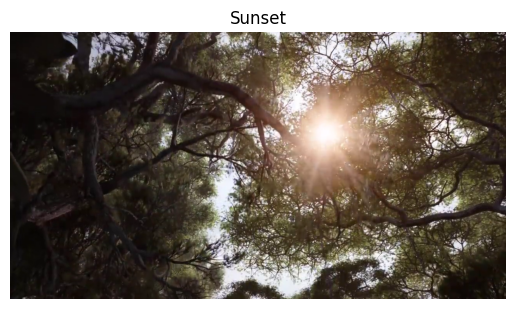

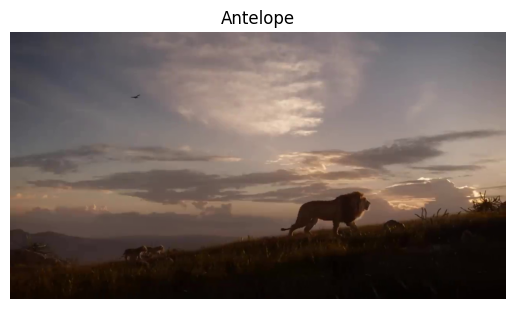

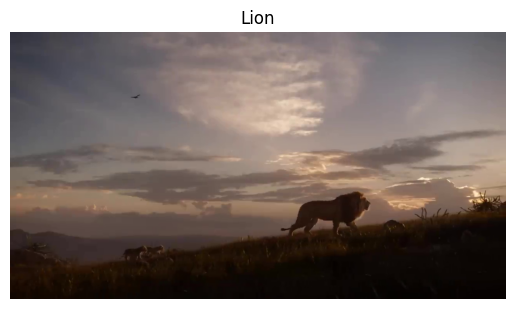

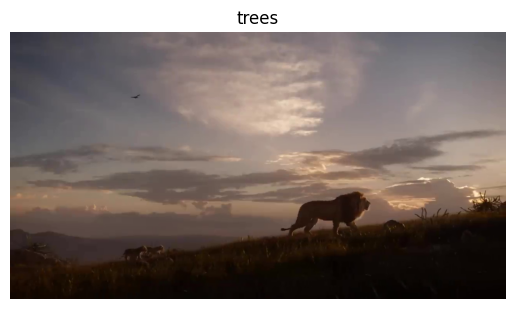

In [25]:
from matplotlib import pyplot as plt

image_idx = np.argmax(logits, axis=0)

for i, img in enumerate(image_idx):
    plt.figure()
    plt.title(search_texts[i])
    plt.axis('off')
    plt.imshow(frames[img][:,:,[2,1,0]]);